# Example
Jupyter Notebooks (.ipynb) are a collection of Python scripts (.py) and/or other types of scripts like Markdown (.md). Double-click this cell to see an example of Markdown. Every notebook run on its own kernel, so two different notebooks can run at the same time, but two scripts in the same notebook can't.

Variables are stored at the notebook level, meaning variables set in one cell can be used in another.

The first script in this notebook collect data from the Raspberry Pi's core and onboard ring oscillator, and save it at the specified location. The second script charts the data and saves it at the specified location.

In [3]:
# import packages
import time # for time stamp
import subprocess as sp # for using system commands and saving the result
import pandas as pd # for DataFrame tools
import matplotlib.pyplot as plt # for charting data
import memex

ModuleNotFoundError: No module named 'pandas'

In [2]:
# script setup
loops = 100 # number of loops
interval = 0.1 # loop interval in seconds
file_name = "data/example.csv" # location of output data (.csv), or just None
print_data = False # print data on 

# print configuration
print("Loops(#):",loops,", Interval(s):",interval,", Time(s):",loops*interval)

# get data using subprocess package and vcgencmd
def get_data(t):
    core_t = float(sp.check_output(["vcgencmd","measure_temp"])[5:9])
    core_f = float(sp.check_output(["vcgencmd","measure_clock","core"])[13:22])/1000000
    core_v = float(sp.check_output(["vcgencmd","measure_volts","core"])[5:11])
    ring_t = str(sp.check_output(["vcgencmd","read_ring_osc"]))
    ring_f = float(ring_t.split('=')[1].split('M')[0])
    ring_v = float(ring_t.split('@')[1].split('V')[0])
    ring_t = float(ring_t[-10:].split('\'')[0])
    return [t,core_t,core_f,core_v,ring_t,ring_f,ring_v]

# initialize dataframe
header = ["AbsTime(s)","CoreTemp(C)","CoreFreq(MHz)","CoreVolt(V)",
          "RingTemp(C)","RingFreq(MHz)","RingVolt(V)"]
data = pd.DataFrame(columns = header)
if print_data:
    print(*header,sep = '\t')

# populate dataframe
new_row = pd.DataFrame()
for i in range(loops):
    t = time.time() # get a timestamp for this loop
    new_row = get_data(t)
    if print_data:
        print(*new_row,sep = '\t')
    else:
        print('.',end='') # print some feedback instead of data
    memex.log(data,header)
    data.loc[len(data)] = new_row
    elapsed = time.time() - t
    if elapsed < interval:
        time.sleep(interval - elapsed)

# save and display dataframe
data.to_csv(file_name,index=False) # save data
print("\nSaved as:",file_name)
display(pd.read_csv(file_name)) # verify

Loops(#): 100 , Interval(s): 0.1 , Time(s): 10.0


NameError: name 'pd' is not defined

,AbsTime(s),CoreTemp(C),CoreFreq(MHz),CoreVolt(V),RingTemp(C),RingFreq(MHz),RingVolt(V)
count,1.000000e+02,100.000000,100.000000,100.0000,100.00000,100.000000,100.0000
mean,1.615847e+09,53.623000,399.999890,1.3188,53.62400,3.339590,1.3188
std,3.479214e+00,1.097551,0.000314,0.0000,1.10911,0.003166,0.0000
min,1.615847e+09,50.500000,399.999000,1.3188,51.00000,3.328000,1.3188
25%,1.615847e+09,53.200000,400.000000,1.3188,53.05000,3.338000,1.3188
50%,1.615847e+09,53.700000,400.000000,1.3188,53.70000,3.340000,1.3188
75%,1.615847e+09,54.350000,400.000000,1.3188,54.80000,3.341000,1.3188
max,1.615847e+09,55.800000,400.000000,1.3188,55.80000,3.346000,1.3188


Saved as: pic/example.jpg


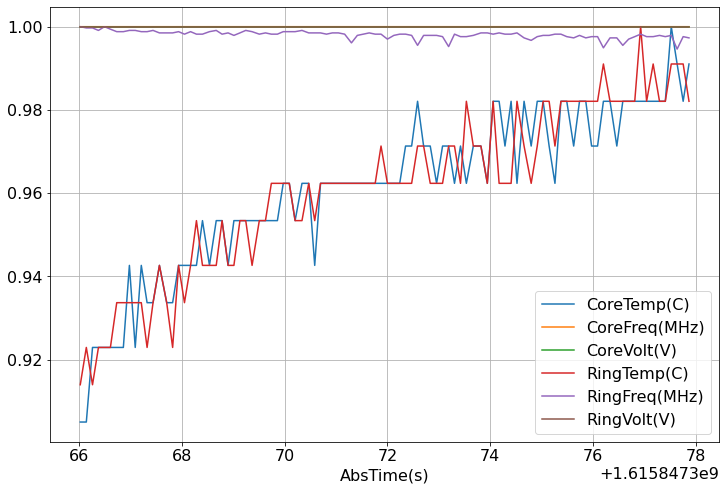

In [3]:
# script setup
chart_name = "pic/example.jpg" # location of saved image
print_stats = True # print descriptive statistics (mean,stdev,median,max)
width = 12 # width of chart
height = 8 # height of chart
text_size = 16 # size of chart text

# convert each column to percentage
def normalize(df):
    df = df.copy(deep=True) # make a copy of the dataframe
    selected = df.columns[1:]
    for c in df[selected].columns:
        df[c] /= df[c].max()
    return df

# descriptive stats
if print_stats:
    display(data.describe())

# draw chart
print("Saved as:",chart_name)
plt.rc("font",size=text_size)
fig = normalize(data).set_index("AbsTime(s)").plot(figsize=(width,height))
fig.grid()
plt.savefig(chart_name)